### Algorithm: Hill Climbing for Optimal DAG Selection from CPDAG

#### Input:
 
 - pc_graph: The graph as a matrix obtained from the PC algorithm.
 
 - max_iterations: A limit on the number of iterations for the hill climbing process.

#### Output:

 - best_graph: The optimal DAG.

 - best_bic: The optimal DAG's BIC score.

 - history: A record of all graphs evaluated, along with their BIC scores and statuses.

#### Procedure:

1. Initialization:

    - best_graph ← an empty matrix.

    - best_bic ← 0 (representing the lowest possible BIC score).

    - history ← an empty list.
    
    - counter ← 0.

2. Check for DAG:
    
    1. If pc_graph is already a DAG:
        
        1. Compute BIC score for pc_graph.
        
        2. Append {"graph": pc_graph, "bic": bic, "status": "initial DAG"} to history.
        
        3. Update best_graph and best_bic

        4. return best_graph and best bic

3. Hill Climbing Process:

    1. While counter < max_iterations:
        
        1. Generate new_graph by assigning directions to undirected edges in pc_graph.
        
        2. Increment counter.

        3. If new_graph is in history

            1. Append {"graph": new_graph, "bic": NA, "status": "Repeated"} to history.
            
            2. break
        
        4. if new_graph is not a DAG

            1. Append {"graph": new_graph, "bic": NA, "status": "Not DAG"} to history.
            
            2. break
        
        5. Calculate BIC score for new_graph.
        
        6. If new_graph's BIC < best_bic:
            
            1. Update best_graph and best_bic.
            
            2. Append {"graph": new_graph, "bic": BIC, "status": "new best"} to history.
            
        7. Else:

        8. Append {"graph": new_graph, "bic": BIC, "status": "not optimal"} to history.

    5. Output:
        1. Return best_graph, best_bic, history.

In [91]:
import numpy as np
import networkx as nx
from pgmpy.estimators import BicScore
from pgmpy.models import BayesianNetwork
import random
from itertools import permutations

In [147]:
import pandas as pd
from castle.common import GraphDAG
from castle.metrics import MetricsDAG
from castle.datasets import DAG, IIDSimulation
from castle.algorithms import PC
from castle.common.priori_knowledge import PrioriKnowledge

method = "linear"
sem_type = "gauss"
n_nodes = 50
n_edges = 25
n = 2000

weighted_random_dag = DAG.erdos_renyi(n_nodes=n_nodes, n_edges=n_edges, weight_range=(0.5, 2.0), seed=1)
dataset = IIDSimulation(W=weighted_random_dag, n=n, method=method, sem_type=sem_type)
true_dag, X = dataset.B, dataset.X

pc = PC()
pc.learn(X)
graph = np.array(pc.causal_matrix)
network = nx.DiGraph(graph)

INFO:root:Finished synthetic dataset


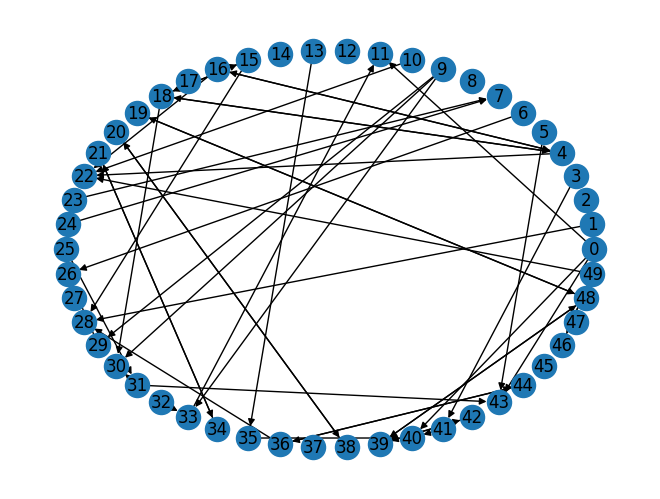

In [148]:
pos = nx.circular_layout(network)
nx.draw(network, pos, with_labels=True)

In [149]:
def find_undirected_pairs(network):
    pairs = set()
    for edge in network.edges():
        if network.has_edge(*edge[::-1]):
            pairs.add(frozenset(edge))
    return [(i, j) for i, j in pairs]

def generate_random_graph(network):
    
    undirected_pairs = find_undirected_pairs(network)
    random_direction = random.sample([0, 1]*len(undirected_pairs), len(undirected_pairs))
    new_network = network.copy()

    for i, j in enumerate(undirected_pairs):
    
        new_network.remove_edge(j[0], j[1])
        new_network.remove_edge(j[1], j[0])
    
        if random_direction[i] == 0:
            new_network.add_edge(j[1], j[0])
        else:
            new_network.add_edge(j[0], j[1])

    return new_network
    
def random_search(X, G, iteration):
    
    history = []
    counter = 0
    
    network = nx.DiGraph(G)
    bic_calculator = BicScore(pd.DataFrame(X))
    
    best_network = network.copy()
    best_bic = float("inf")
    
    if nx.is_directed_acyclic_graph(network):
        bic = bic_calculator.score(network)
        best_network = network.copy()
        best_bic = bic
        
        history.append({"network": best_network, "bic": best_bic, "status": "Inpu is DAG"})
    
    else:
    
        while counter < iteration:
            counter += 1
            new_network = generate_random_graph(network)
            
            if any([set(new_network.edges()) == set(i["network"].edges()) for i in history]):
                history.append({"network": new_network, "bic": bic, "status": "Repeated"})
                
            elif nx.is_directed_acyclic_graph(new_network) == False:
                history.append({"network": new_network, "bic": 0, "status": "Not DAG"})
                
            else:
                bic = bic_calculator.score(new_network)
                
                if bic < best_bic:
                    best_network = new_network.copy()
                    best_bic = bic
                    history.append({"network": new_network, "bic": bic, "status": "Best DAG"})
                    
                else:
                    history.append({"network": new_network, "bic": bic, "status": "Worse DAG"})
    
    return best_network, best_bic, history

In [150]:
best_network, best_bic, history = random_search(X, network, 50)

In [151]:
print(best_bic)

-1.2179692188031442e+17


In [152]:
import plotly_express as px
px.scatter(
    pd.DataFrame({"bic": [i["bic"] for i in history], "status": [i["status"] for i in history]}),
    x = range(len(history)),
    y = "bic",
    color = "status"
)


In [163]:
# All Possible New Edges = All Possible Edges - Current Edges - Reversed Edges
edges = len(set(permutations(best_network.nodes(), 2)) - set(best_network.edges()) - set([(j, i) for i, j in best_network.edges()]))


2374

In [ ]:
potential_new_edges = (
            set(permutations(self.variables, 2))
            - set(model.edges())
            - set([(Y, X) for (X, Y) in model.edges()])
        )